In [178]:
#IN google colab install abtem and pycu for gpu acceleration:
#!pip install abtem
#!pip install pycu



from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 10)

from ase.io import read
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell

from ase.spacegroup import crystal

from ase.visualize import view

from abtem.transfer import scherzer_defocus
import numpy as np

import matplotlib.pyplot as plt

from abtem.utils import fft_shift
from abtem.aperture import DeviatedAnularAperture
from abtem.aperture import DeviatedAperture
import scipy.constants as c

from collections import defaultdict

from abtem.transfer import cartesian2polar
from abtem.transfer import Haider2Krivanek
from ase.lattice.cubic import Diamond
import numpy as np
from ase import Atoms

current version: 1.0.0beta27


In [2]:
def imshow(X, *args, **kwargs): # it seems so that reciprocal arrays (phi or alpha or result of evaluating ctf or aperture) are transformed so that it is neccessary to firstly use fftshift and then mirror the values along axis=0. In arrays which are in direct space (probe image) via probe.build().intensity().array[0] it suffices only to morror the image along axis=0. 
    return plt.imshow(X=np.flip(X,axis=0),*args, **kwargs)
    #return plt.imshow(X=np.swapaxes(X,0,1),*args, **kwargs)
    #return plt.imshow(X=np.swapaxes(np.flip(X,axis=0),0,1),*args, **kwargs)

# SrTiO$_3$

We build an atomic structure of MoS2 with ASE. Since abTEM requires an orthogonal we make the cell orthogonal. We also need to repeat the structure, so the probe fits inside the cell.

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

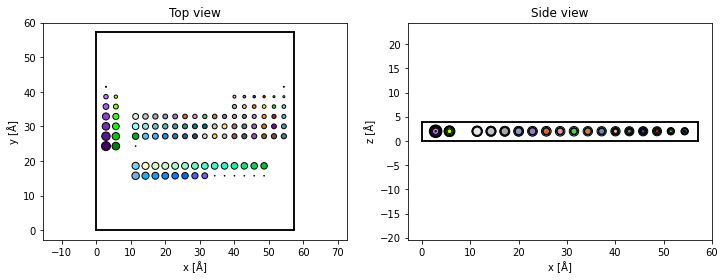

In [3]:
# following was created by modifiying example in https://wiki.fysik.dtu.dk/ase/gallery/gallery.html?highlight=periodic%20table
# generates column, row positions for each element
zmax = 103
x, y = 1, 1  # column, row , initial coordinates for Hydrogen
positions = np.zeros((zmax + 1, 3))
for z in range(1, zmax + 1):
    if z == 2:
        x += 16
    if z == 5:
        x += 10
    if z == 13:
        x += 10
    if z == 57 or z == 89:
        y += 3
    if z == 72 or z == 104:
        y -= 3
        x -= 14
        
    positions[z] = (x, -y, 0)
    x += 1
    
    if z==71:
        positions[z] = (3,-6,0)
    if z==103:
        positions[z] = (3,-7,0)
    
    if x > 18:
        x = 1
        y += 1

spacing = 2.86


positions[positions[:,0]>=3]+=np.array([1,0,0])

atoms_z=np.arange(1, zmax + 1)
atoms_positions=positions[1:] * spacing
atoms = Atoms(atoms_z, positions=atoms_positions,cell=np.array([20,20,20])*spacing)


atoms.center(vacuum=2, axis=2)
atoms.center(axis=1)
atoms.center(axis=0)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [4]:
view(atoms)

In [5]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([57.199999999999996, 57.199999999999996, 3.999999999999998])


We create and calculate the electrostatic potential.

In [6]:
gpts=2048
potential = Potential(atoms, 
                      gpts=gpts,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland')

potential = potential.build()

4

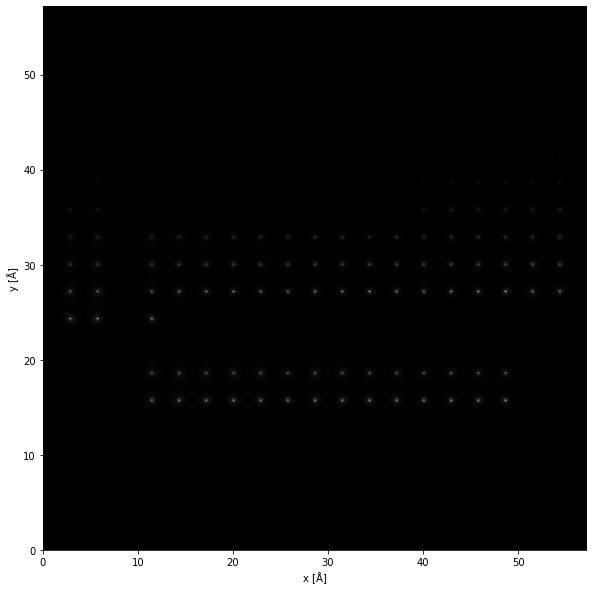

In [7]:
potential.project().show()
len(potential)

In [8]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.027929687499999998, 0.027929687499999998)


In [9]:
def get_coeffs(C1,A1,C3,B2=0*1j,A2=0+0*1j): #parameters in argumentC1,A1,.. are original values of aberations in [m]
    A0=0+0*1j
    cartesian = Haider2Krivanek(C1,A1,C3,B2,A2)
    return(A0.real/1e-10,A0.imag/1e-10,cartesian2polar(cartesian)) #returning in angstrems

In [10]:
energy=400e3
phi_star=energy*(1-c.elementary_charge*energy/2/c.m_e/c.c**2)

#temporal coherrence
Cc=1.61e-3/1e-10 # In Angstrem
focal_spread=Cc*(0.6/200e3)

#spatial coherrence
reduced_brightness=1e8 
d=0.6*2*1e-10 # from graph below with C3=0 
I=0.2e-9
alphaa=np.sqrt(4*I/np.pi**2/d**2/reduced_brightness/phi_star)
beta=1/np.e*alphaa*1e3#1/e of angle distribution in [mrad]
angular_spread=beta


_, _, aberations_dict = get_coeffs(C1=0,A1=0,C3=1.3e-3)#C3=2.7e-3)#1.9e-3)
defocus_0=scherzer_defocus(Cs=aberations_dict["C30"],energy=energy) 

In [11]:
#semiangle_cutoff=9.5
#semiangle_cutoff=8
#semiangle_cutoff=17
semiangle_cutoff=9.3

In [12]:
aperture = DeviatedAnularAperture(aperture_angle=semiangle_cutoff,inner_aperture_angle=0,spokes=0,spoke_thickness=0)
probe = Probe(energy=energy, aperture=aperture, semiangle_cutoff=semiangle_cutoff, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"],C50=30.7e7)#, angular_spread=angular_spread,focal_spread=focal_spread)

To run this simulation using PRISM instead of the standard multislice algorithm, uncomment the cell below. Note that while PRISM may be up to a 1000 times faster than multislice for large structures, the performance is fairly similar for small simulations like this.

In [13]:
#probe = SMatrix(energy=energy, semiangle_cutoff=11.3, expansion_cutoff=20, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"])
#probe = SMatrix(energy=energy, semiangle_cutoff=9.5, expansion_cutoff=20, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"],angular_spread=angular_spread,focal_spread=focal_spread)
#_, _, aberations_dict = get_transformed_coeffs(C1=-defocus_0*1e-10,A1=0,C3=1.9e-3,delta=0e-3+0*1j) 
#probe.ctf.set_parameters(aberations_dict)

In [14]:
print("defocus_0: ",defocus_0)
print("angular_spread: ",angular_spread)
print("focal_spread: ",focal_spread)

defocus_0:  566.1880999039493
angular_spread:  5.5939675105339
focal_spread:  48.300000000000004


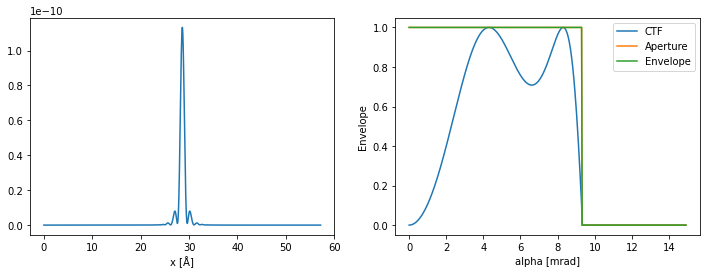

In [15]:
probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

probe.profile().show(ax=ax1);

probe.ctf.show(ax=ax2);

In [16]:
from abtem.device import get_array_module, get_device_function
def convolution(array_1,array_2):
    xp = get_array_module(array_1)
    fft2 = get_device_function(xp, 'fft2')
    fft2_convolve = get_device_function(xp, 'fft2_convolve')
    
    kernel = fft2(array_2,overwrite_x=False)
    result = fft_shift(fft2_convolve(array_1, kernel, overwrite_x=False),np.array([gpts//2,gpts//2]))
    return(result)

In [17]:
proj_pot = potential.project().array.astype(np.complex64)*c.e*1e-10 # in joule*meter
xp = get_array_module(proj_pot)
fft2 = get_device_function(xp, 'fft2')
ifft2 = get_device_function(xp, 'ifft2')

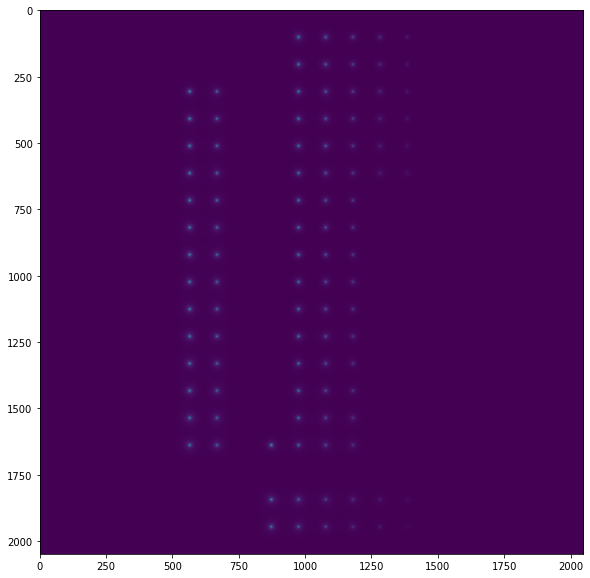

In [18]:
imshow(np.abs(proj_pot))

WPA in Bosch paper results in image intensity in form of: 

$I_\mathrm{WPA}= \int \int \sin \varphi(\vec{r}+\vec{r}_\mathrm{p})\cdot i \cdot \big(B(\vec{r})-\overline{B(\vec{r})}\big)\mathrm{d}^2\vec{r} = \Big( i \cdot \big(B(\vec{r})-\overline{B(\vec{r})}\big)\mathrm{d}^2\vec{r} \star \sin \varphi(\vec{r}) \Big)(\vec{r}_\mathrm{p}) = \Big(\overline{ i \cdot \big(B(\vec{-r})-\overline{B(\vec{-r})}\big)} * \sin \varphi(\vec{r}) \Big)(\vec{r}_\mathrm{p})$

where 

$B(\vec{r})=\psi_\mathrm{in}(\vec{r})\cdot\mathscr{F}\Big\{W(\vec{k})\cdot \mathscr{F}^{-1}\big\{ \overline {\psi_\mathrm{in}(\vec{r}')} \big\}(\vec{k})\Big\}(\vec{r})$

as a side note for a detector with BF small axial detector $W(k) = \delta(k)$ we get:

$B=\psi_\mathrm{in}(\vec{r})\cdot\mathscr{F}\Big\{\delta(\vec{k})\cdot \mathscr{F}^{-1}\big\{\overline{ \psi_\mathrm{in}(\vec{r}') }\big\}(\vec{k})\Big\}(\vec{r})=\psi_\mathrm{in}(\vec{r})\cdot\mathscr{F}\Big\{\delta(\vec{k})\cdot \overline{\psi(\vec{-k})} \Big\}(\vec{r})$

where was used $\mathscr{F}^{-1}\{\overline{a(\vec{r})}\}=\overline{A(-\vec{k})}$ and finaly because $\psi(\vec{k}=\vec{0})=\exp{\big\{\frac{2\cdot\pi}{\lambda}\chi(\vec{k}=\vec{0})\big\}}=1$ we get:

$B=\psi_\mathrm{in}$ 

which is the result of Kirkland's WPA equation (3.9):

$1+\sigma_\mathrm{e}v_\mathrm{z}(\vec{r}) * [ i h_\mathrm{0}(\vec{r})-i \overline{h_\mathrm{0}(\vec{r})} ]$

where $*$ denotes convolution and $h_\mathrm{0}$ is point spread function ... $\psi_{in}({\vec{r}})=h_\mathrm{0}$



In [19]:
probe_array = probe.build().array[0]

alpha, phi = probe.get_scattering_angles()
detector_array = DeviatedAnularAperture(aperture_angle=semiangle_cutoff/2,inner_aperture_angle=0,spokes=0).evaluate(alpha=alpha,phi=phi)


B = probe_array*fft2(detector_array*ifft2(probe_array.conjugate()))
#B = probe_array*fft_shift(fft2(detector_array*ifft2(probe_array.conjugate())),np.array([gpts//2,gpts//2]))
array_1 = 1j*(B-B.conjugate())
#array_1 = 1j*(probe_array-probe_array.conjugate())# approx of infinitely small detector on the optical axes..
electron_energy=probe.energy*c.e # electron energy in joules

wavelength=probe.wavelength*1e-10 # in meters
#follows interaction parameter in rad/joule/meter
interaction_parameter = 2*np.pi/wavelength/electron_energy*((c.m_e*c.c**2+c.e*electron_energy)/(2*c.m_e*c.c**2+c.e*electron_energy))#kirkland (5.6)
phase_shift=proj_pot*interaction_parameter #kirkland (5.7)
#array_2 = np.sin(phase_shift)
array_2 = phase_shift
#according to second term of equation (18) in Bosch for WPE I should do crosscorelation() of 
I_WPA = convolution(array_2,array_1[::-1,::-1].conjugate()) #cross corelation

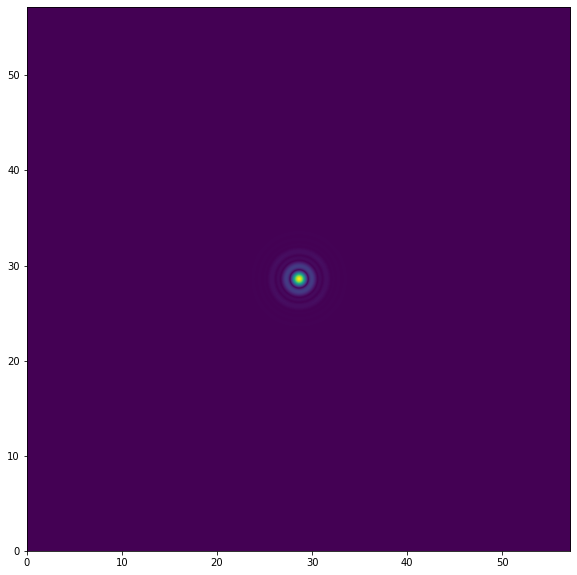

In [20]:
calibration=probe.profile().calibrations[0]
extent=gpts*calibration.sampling
imshow(np.abs(array_1),extent=(0,extent,0,extent))

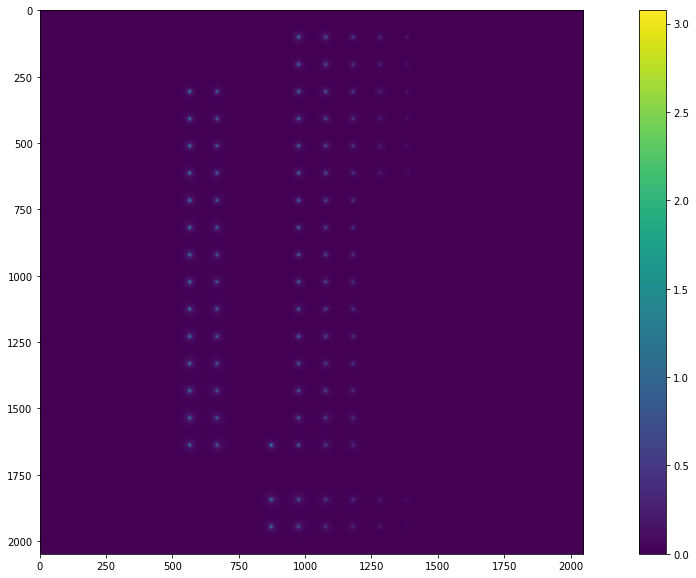

In [21]:
imshow(np.abs(phase_shift))
plt.colorbar()

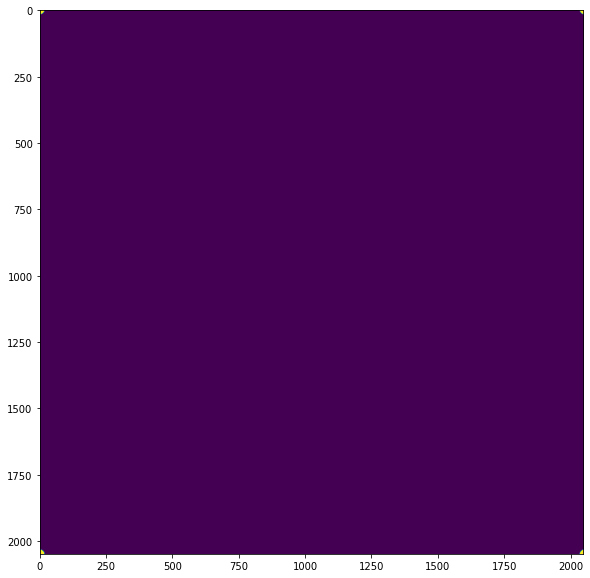

In [40]:
#%matplotlib inline
imshow(detector_array)

The parameters were set so that they are the same as in figure (5.17b) ... energy - 400keV, Scherzer defocus, aperture semiangle - 9.33 mrad. The figure are similar:

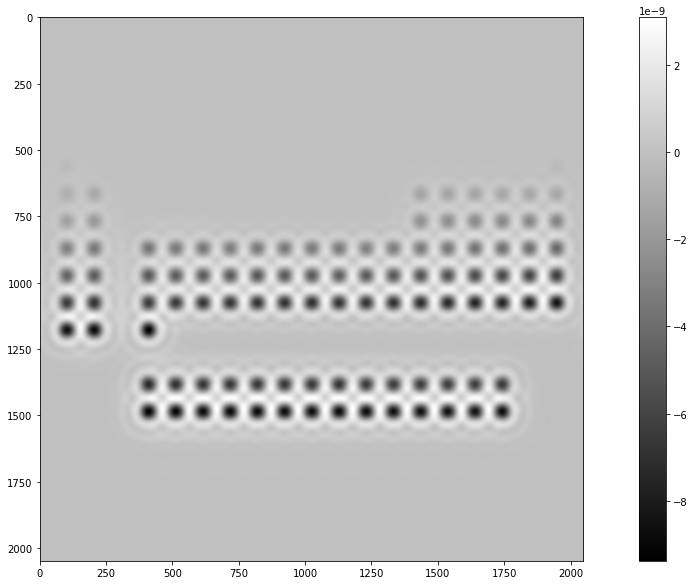

In [195]:
imshow(np.swapaxes(np.real(I_WPA),0,1),cmap='gray');plt.colorbar()

Scan:   0%|          | 0/20736 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f806f500490>)

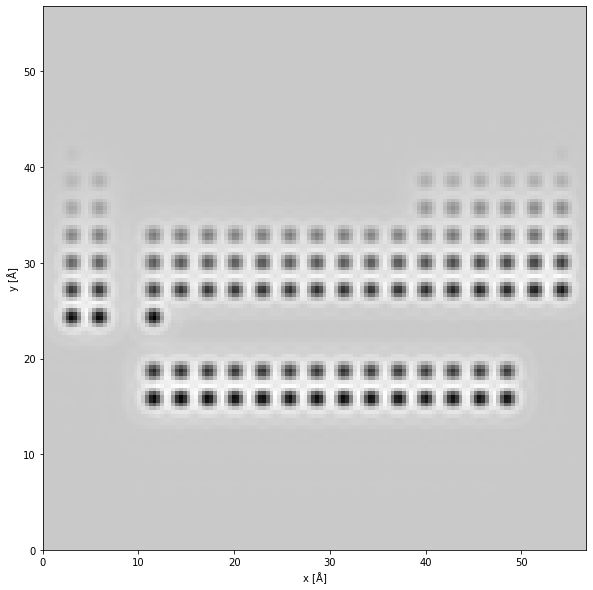

In [24]:
detector = FlexibleAnnularDetector()
start = np.array([0,0]) # it is supposed to be in angstrems
end = np.array((potential.extent[0], potential.extent[1]))
gridscan = GridScan(start=start, end=end, sampling=probe.ctf.nyquist_sampling * .9)

measurement_deviated = probe.scan(gridscan, detector, potential)
measurement_deviated.integrate(0,semiangle_cutoff/2).show()

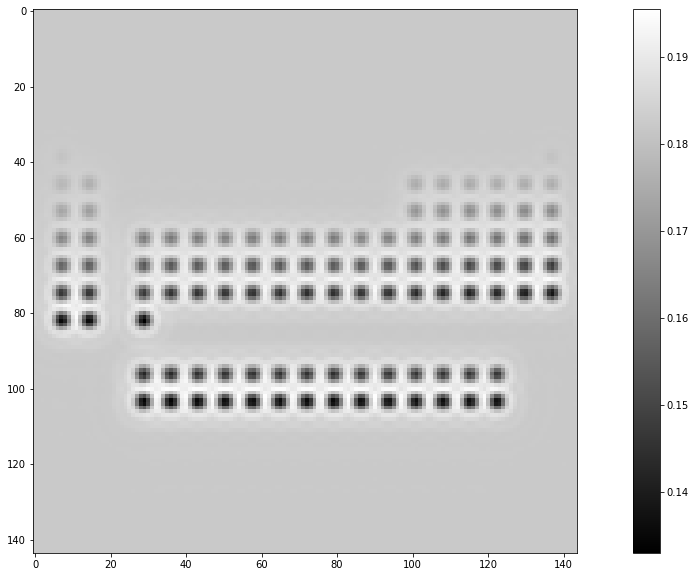

In [250]:
imshow(np.swapaxes(measurement_deviated.integrate(0,semiangle_cutoff/2).array,0,1),cmap="gray");plt.colorbar()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f803c7ed250>)

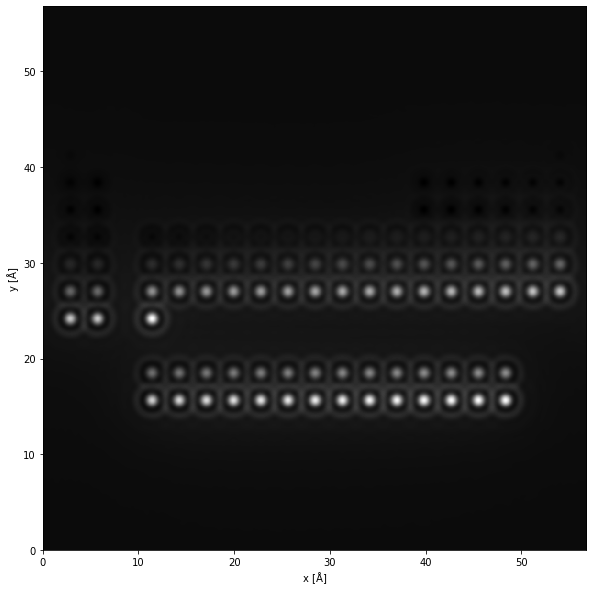

In [27]:
measurement_deviated.integrate(semiangle_cutoff,semiangle_cutoff*4).tile((1,1)).interpolate(.05).show()

In [334]:
rho=0.055e-9

probe_array = probe.build().array[0]
#norm = np.sum(probe_array*probe_array.conjugate()).real*dr_sq


electron_energy=probe.energy*c.e # electron energy in joules

wavelength=probe.wavelength*1e-10 # in meters
#follows interaction parameter in rad/joule/meter
interaction_parameter = 2*np.pi/wavelength/electron_energy*((c.m_e*c.c**2+c.e*electron_energy)/(2*c.m_e*c.c**2+c.e*electron_energy))#kirkland (5.6)
phase_shift=proj_pot*interaction_parameter #kirkland (5.7)




alpha, phi = probe.get_scattering_angles()
w=0.5
detector_array = DeviatedAnularAperture(aperture_angle=semiangle_cutoff*w,inner_aperture_angle=0,spokes=0).evaluate(alpha=alpha,phi=phi)


B = probe_array*fft2(detector_array*ifft2(probe_array.conjugate()))
#B = probe_array*fft_shift(fft2(detector_array*ifft2(probe_array.conjugate())),np.array([gpts//2,gpts//2]))

#ctf equivalents:
c_1 = 1j*(B-B.conjugate())
c_2 = -(B+B.conjugate())
c_3 = probe_array*probe_array.conjugate()

#object equivalents:
o_1 = xp.sin(phase_shift)
o_2 = 1-xp.cos(phase_shift)
o_3 = 1-xp.cos(phase_shift)

y,x = np.indices(detector_array.shape)
x = (x - (potential.gpts[0]-1)/2) * potential.sampling[0]*1e-10
y = (y - (potential.gpts[1]-1)/2) * potential.sampling[1]*1e-10 #conctructing x,y grid so that for gpts=4 x is like [-1.5,-0.5,0.5,1.5 ]... it is neccesary to fftshift either r or integrated values.. fftshifting r:
r = xp.sqrt(x**2 + y**2)
r = xp.abs(fft_shift(r,np.array(potential.gpts)//2)) # result should be real so i am making it real with abs
sampling = np.array(potential.sampling)*1e-10
dr_sq=sampling[0]*sampling[1]
integral = 2*xp.sum(fft2(detector_array.astype(np.complex64) )[r < rho])*dr_sq # detector_array is real and fft2 output is complex therfore it is necessary to convert the real values to complex

#according to equation (24) in Bosch:
I_1 = convolution(o_1,c_1[::-1,::-1].conjugate())
I_2 = convolution(o_2,c_2[::-1,::-1].conjugate())
I_3 = convolution(o_3,c_3[::-1,::-1].conjugate())
I_TOT=I_1 + I_2 + I_3

In [325]:
print(np.sum(r<rho))
print(np.size(r))

1224
4194304


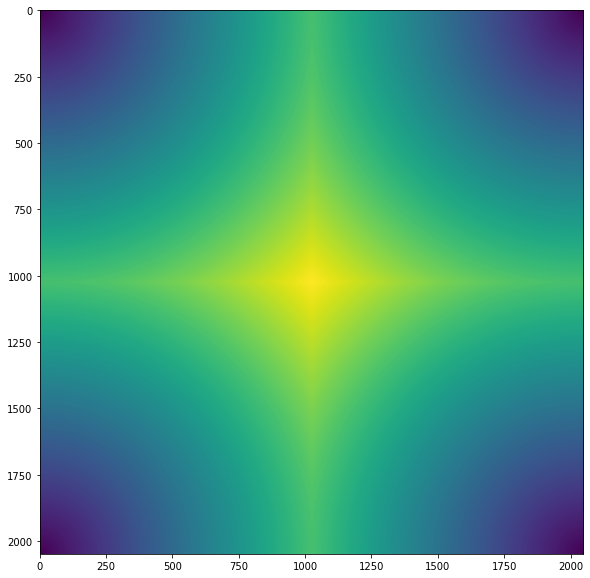

In [326]:
#%matplotlib inline
imshow(r)

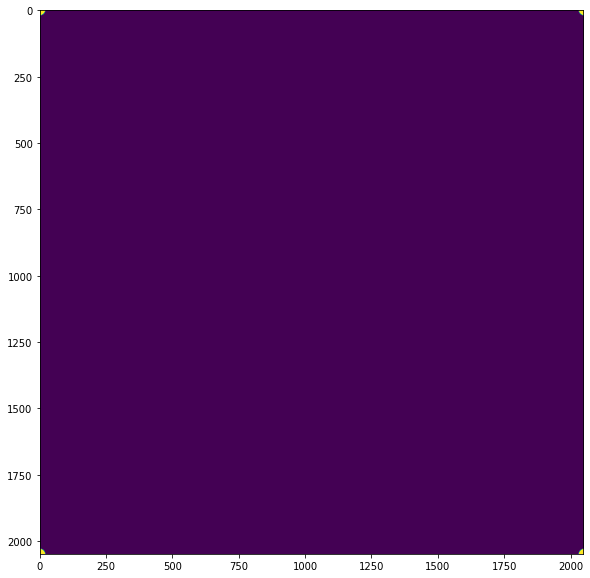

In [327]:
#%matplotlib qt
imshow(r<rho)

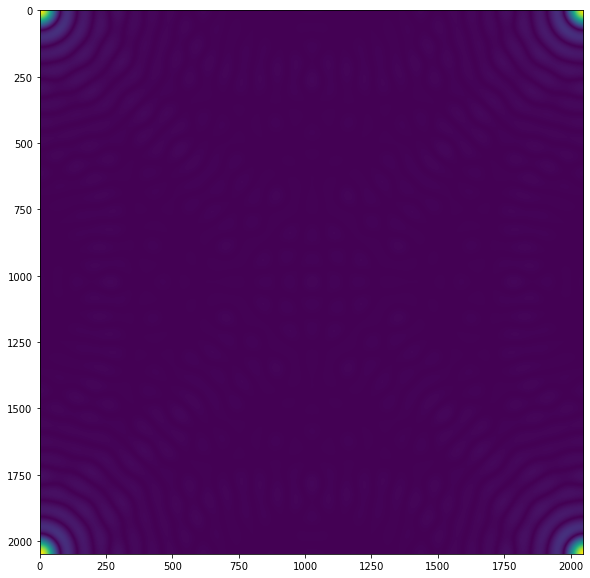

In [328]:
imshow(np.abs(fft2(detector_array.astype(np.complex64) )))

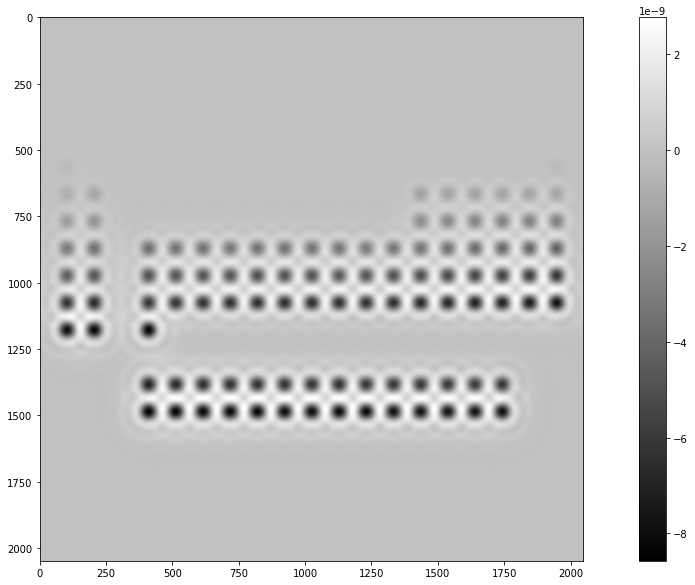

In [329]:
imshow(np.swapaxes(np.real(I_1),0,1),cmap="gray");plt.colorbar()

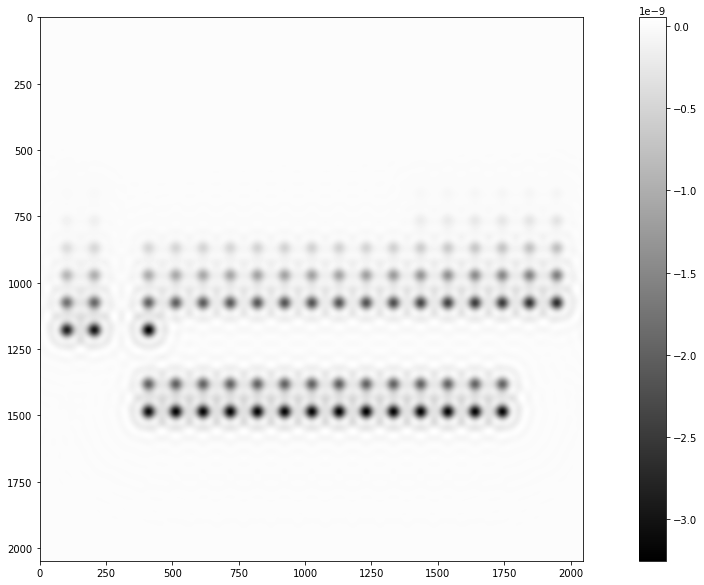

In [330]:
imshow(np.swapaxes(np.real(I_2),0,1),cmap="gray");plt.colorbar()

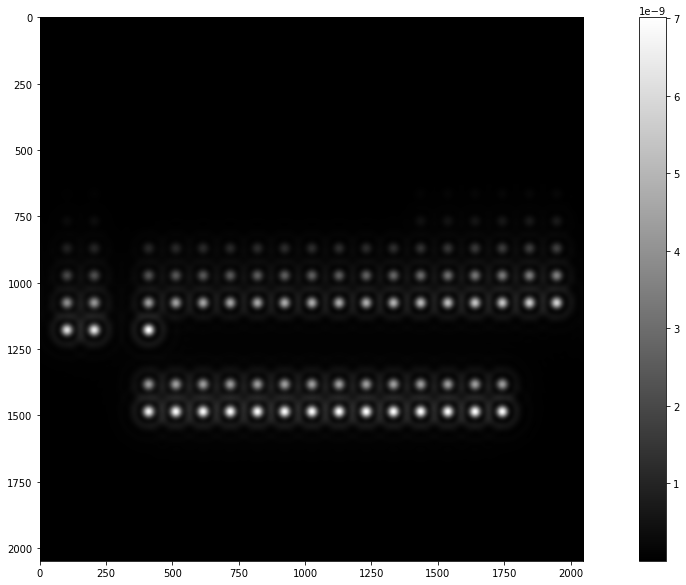

In [335]:
imshow(np.swapaxes(np.real(I_3),0,1),cmap="gray");plt.colorbar()

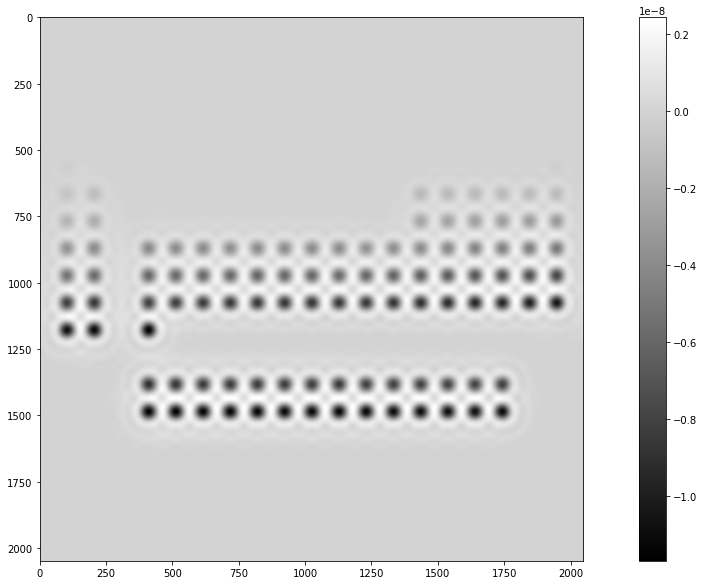

In [332]:
imshow(np.swapaxes(np.real(I_TOT),0,1),cmap="gray");plt.colorbar()

In [303]:
integral

(1.4896053822851182e-17+7.776020312721954e-27j)

In [224]:
dr_sq

7.800674438476563e-24

In [235]:
sampling

array([2.79296875e-12, 2.79296875e-12])

In [263]:
rho

5.5e-11

In [276]:
np.sum(probe_array*probe_array.conjugate())*dr_sq

/tmp/ipykernel_2075277/3132069373.py:1: RuntimeWarning: overflow encountered in multiply
  np.sum(probe_array*probe_array.conjugate())*dr_sq
/tmp/ipykernel_2075277/3132069373.py:1: RuntimeWarning: invalid value encountered in multiply
  np.sum(probe_array*probe_array.conjugate())*dr_sq


(nan+nanj)

In [283]:
np.sum(probe_array*probe_array.conjugate()).real*dr_sq

1.8598261590724656e-30